In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,average_precision_score

In [2]:
# Check if CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Frame Data
Z = None

def load_data(dataset_path, selected_classes_id, selected_modulation_classes, N_SNR=4):
    with h5py.File(dataset_path, "r") as dataset_file:
        X_data = None
        y_data = None
        z_data = None
        for id in selected_classes_id:
            X_slice = dataset_file['X'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]
            y_slice = dataset_file['Y'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]
            z_slice = dataset_file['Z'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]
            if X_data is not None:
                X_data = np.concatenate([X_data, X_slice], axis=0)
                y_data = np.concatenate([y_data, y_slice], axis=0)
                z_data = np.concatenate([z_data, z_slice], axis=0)
            else:
                X_data = X_slice
                y_data = y_slice
                z_data = z_slice
    
    X_data = X_data.reshape(len(X_data), 32, 32, 2)
    y_data_df = pd.DataFrame(y_data)
    Z = z_data
    
    print(f"Original y_data shape: {y_data_df.shape}")
    print(f"Columns with non-zero sum: {(y_data_df.sum() != 0).sum()}")
    non_zero_columns = y_data_df.columns[y_data_df.sum() != 0]
    y_data_df = y_data_df[non_zero_columns]
    print(f"Filtered y_data shape: {y_data_df.shape}")
    
    if y_data_df.empty:
        raise ValueError("All columns in y_data have zero sum. Check your data and selected classes.")
    
    y_indices = np.argmax(y_data_df.values, axis=1)
    
    class_mapping = {i: cls for i, cls in enumerate(selected_modulation_classes)}
    mapped_classes = [class_mapping[i] for i in y_indices]
    
    return X_data, y_indices, Z, mapped_classes, selected_modulation_classes

def split_data(X, y, Z, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(
        X, y, Z, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test, Z_train, Z_test

# Usage example:
def load_and_split_data(dataset_path, selected_classes_id, selected_modulation_classes, N_SNR=4, test_size=0.4, random_state=42):
    X, y, Z, mapped_classes, class_names = load_data(dataset_path, selected_classes_id, selected_modulation_classes)
    X_train, X_test, y_train, y_test, Z_train, Z_test = split_data(X, y, Z, test_size, random_state)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    print(f"Number of classes: {len(class_names)}")
    
    return X_train, X_test, y_train, y_test, Z_train, Z_test, class_names

In [4]:
# wandb login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api_key") 
wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
def evaluate_pipeline(pipeline, X_test, y_test, class_names):
    wandb.init(project="radioml-evaluation", name="pipeline-evaluation")

    # Ensure X_test is a tensor and on the correct device
    if not isinstance(X_test, torch.Tensor):
        X_test = torch.from_numpy(X_test).float()
    X_test = X_test.to(device)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)

    # Move predictions back to CPU for sklearn metrics
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    if isinstance(y_pred_proba, torch.Tensor):
        y_pred_proba = y_pred_proba.cpu().numpy()

    # Print shapes and unique values
    print(f"y_test shape: {y_test.shape}, unique values: {np.unique(y_test)}")
    print(f"y_pred shape: {y_pred.shape}, unique values: {np.unique(y_pred)}")
    print(f"Number of class_names: {len(class_names)}")

    # Ensure y_test and y_pred are 1D arrays
    y_test = y_test.ravel()
    y_pred = y_pred.ravel()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Use np.unique to get the actual labels present in the data
    labels = np.unique(np.concatenate((y_test, y_pred)))
    class_report = classification_report(y_test, y_pred, labels=labels, target_names=[class_names[i] for i in labels], output_dict=True)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Log metrics to wandb
    wandb.log({
        "accuracy": accuracy,
        "classification_report": wandb.Table(dataframe=pd.DataFrame(class_report).transpose())
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.close()

    # ROC Curve and AUC
    n_classes = len(class_names)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    wandb.log({"roc_curve": wandb.Image(plt)})
    plt.close()

    # Precision-Recall Curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
        plt.plot(recall[i], precision[i], lw=2, 
                 label=f'{class_names[i]} (AP = {average_precision[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    wandb.log({"precision_recall_curve": wandb.Image(plt)})
    plt.close()

    # Feature Importances
    if hasattr(pipeline.named_steps['xgb_classifier'], 'feature_importances_'):
        feature_imp = pipeline.named_steps['xgb_classifier'].feature_importances_
        feature_imp_df = pd.DataFrame({'feature': [f'feature_{i}' for i in range(len(feature_imp))],
                                       'importance': feature_imp})
        feature_imp_df = feature_imp_df.sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_imp_df.head(20))
        plt.title('Top 20 Feature Importances')
        wandb.log({"feature_importances": wandb.Image(plt)})
        plt.close()

        wandb.log({"feature_importance_table": wandb.Table(dataframe=feature_imp_df)})
    else:
        print("Feature importances not available for this model.")

    wandb.finish()

In [6]:
class SEBlock(nn.Module):
    """ Squeeze-and-Excitation Block """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

class MultiHeadAttention(nn.Module):
    """ Multi-Head Attention Module """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return attn_output

class RadioNet(nn.Module):
    def __init__(self, num_classes):
        super(RadioNet, self).__init__()

        # Separate Convolutional Pathways for I and Q
        self.q_conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SEBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            SEBlock(256),
            nn.MaxPool2d(2, stride=2)
        )

        self.i_conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SEBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            SEBlock(256),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_size = self._get_conv_output((1, 32, 32))

        # Bidirectional LSTM with Layer Normalization
        self.lstm = nn.LSTM(self.feature_size * 2, 512, num_layers=2, 
                            batch_first=True, bidirectional=True, dropout=0.3)
        self.layer_norm = nn.LayerNorm(1024)  # Layer normalization after LSTM

        # Multi-Head Attention with multiple heads
        self.multi_head_attn = MultiHeadAttention(1024, num_heads=8)

        # Enhanced Fully Connected Layers with Dense Connections
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.1)
        )

        self.output = nn.Linear(64, num_classes)

    def _get_conv_output(self, shape):
        input = torch.rand(1, *shape)
        output = self.q_conv(input)
        return int(torch.numel(output) / output.shape[0])

    def forward(self, i_input, q_input):
        q = self.q_conv(q_input)
        q = q.view(q.size(0), -1)

        i = self.i_conv(i_input)
        i = i.view(i.size(0), -1)

        combined = torch.cat((q, i), dim=1)
        combined = combined.unsqueeze(1)  # Add sequence dimension

        lstm_out, _ = self.lstm(combined)
        lstm_out = self.layer_norm(lstm_out)

        # Apply Multi-Head Attention
        attn_output = self.multi_head_attn(lstm_out)
        context = torch.sum(attn_output, dim=1)  # Sum up the attended output

        x = self.fc(context)
        x = self.output(x)

        return torch.log_softmax(x, dim=1)
    

In [7]:
class FrozenFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.model.eval()
        with torch.no_grad():
            features_list = []
            for batch in DataLoader(X, batch_size=32):
                batch = batch.to(device)
                i_input = batch[:, :, :, 0].unsqueeze(1)
                q_input = batch[:, :, :, 1].unsqueeze(1)

                features = self.model.fc(self.model.multi_head_attn(self.model.layer_norm(self.model.lstm(torch.cat((
                    self.model.q_conv(q_input).view(q_input.size(0), -1),
                    self.model.i_conv(i_input).view(i_input.size(0), -1)
                ), dim=1).unsqueeze(1))[0])).sum(dim=1))

                features_list.append(features.cpu().numpy())

            return np.vstack(features_list)
        

In [8]:
# Inference
dataset_path = "/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5"
pipeline_path = "/kaggle/input/xgbnet/pytorch/default/1/trained_pipeline.joblib"

base_modulation_classes = [
    'OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
    '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
    '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
    'FM', 'GMSK', 'OQPSK'
]
selected_modulation_classes = [
    '4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 'FM', 'AM-DSB-WC', '32APSK'
]
selected_classes_id = [base_modulation_classes.index(cls) for cls in selected_modulation_classes]

In [9]:
def find_modulation_snr_indices(modulation_name, snr_level, classes, Y, Z):
    modulation_index = classes.index(modulation_name)
    indices = [i for i, (label, snr) in enumerate(zip(Y, Z)) if label == modulation_index and snr == snr_level]
    return indices

def plot_signals_by_modulation_snr(X, Y, Z, classes, modulation_name, snr_level, num_samples):
    indices = find_modulation_snr_indices(modulation_name, snr_level, classes, Y, Z)
    if len(indices) < num_samples:
        print(f"Not enough samples for {modulation_name} with SNR {snr_level} dB. Found only {len(indices)} samples.")
        return
    samples = np.random.choice(indices, num_samples, replace=False)
    for sample in samples:
        plt.figure(figsize=(30, 3))
        I_phase = X[sample, :, 0].flatten()
        Q_phase = X[sample, :, 1].flatten()
        magnitude = np.sqrt((I_phase**2) + (Q_phase**2))
        plt.subplot(1, 3, 1)
        plt.plot(I_phase)
        plt.title(f'{modulation_name} - In-phase (I) (SNR: {snr_level} dB)')
        plt.subplot(1, 3, 2)
        plt.plot(Q_phase)
        plt.title(f'{modulation_name} - Quadrature-phase (Q) (SNR: {snr_level} dB)')
        plt.subplot(1, 3, 3)
        plt.plot(magnitude)
        plt.title(f'{modulation_name} - Magnitude (SNR: {snr_level} dB)')
        plt.tight_layout()
        plt.show()

Original y_data shape: (131072, 24)
Columns with non-zero sum: 8
Filtered y_data shape: (131072, 8)


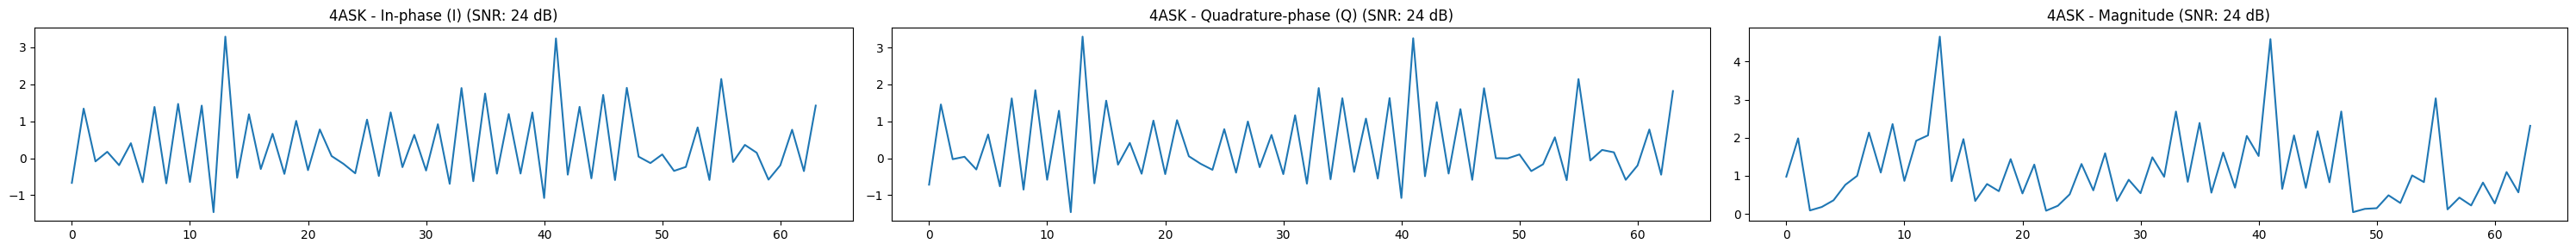

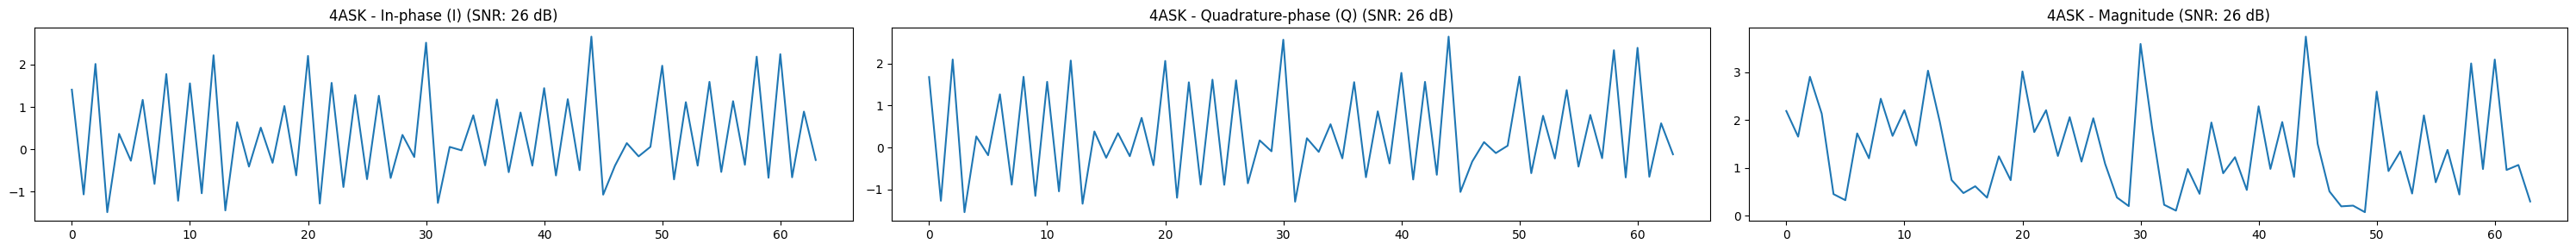

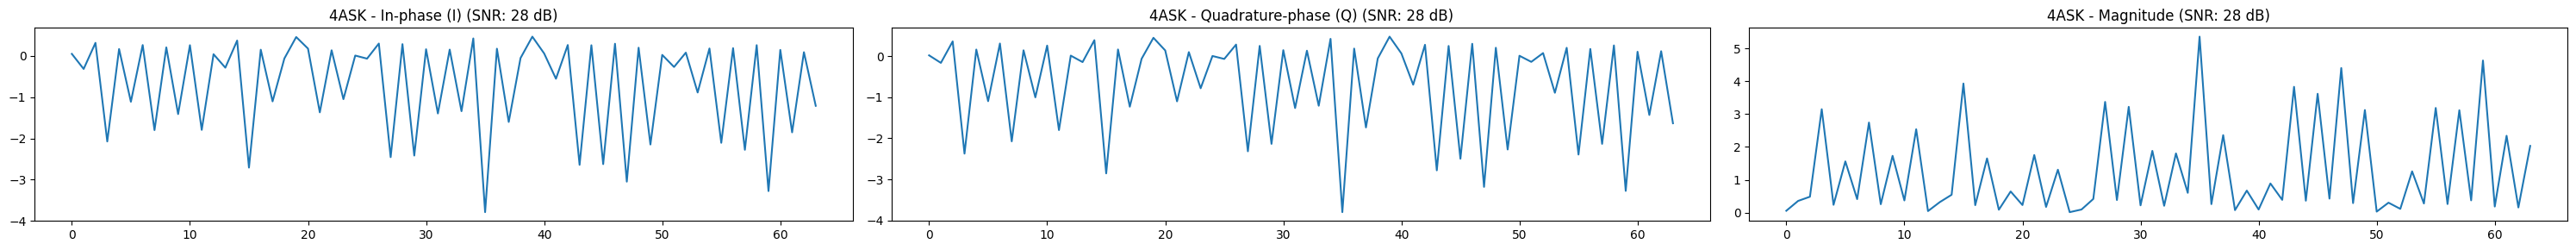

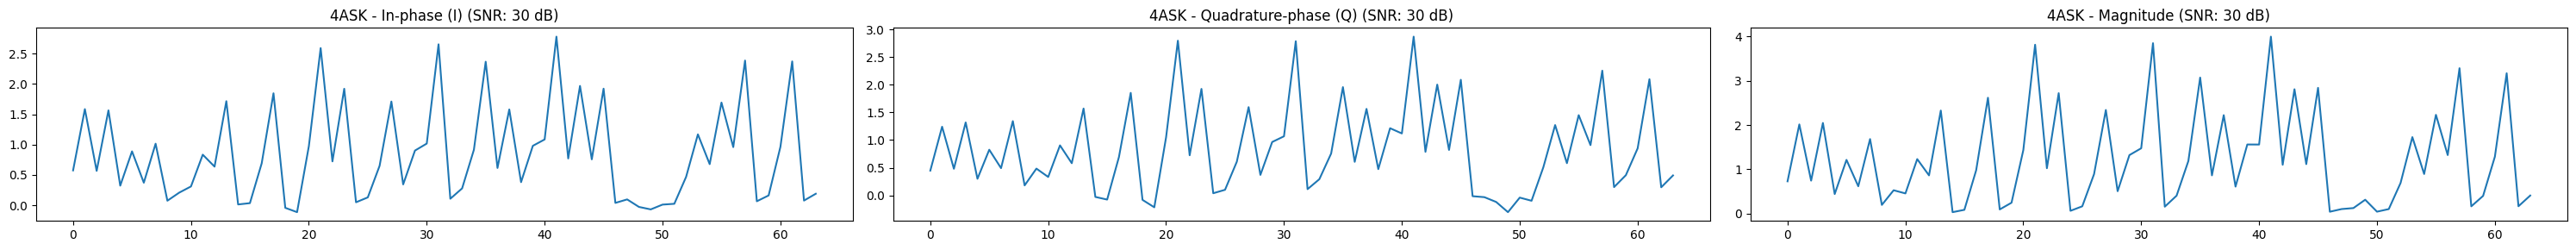

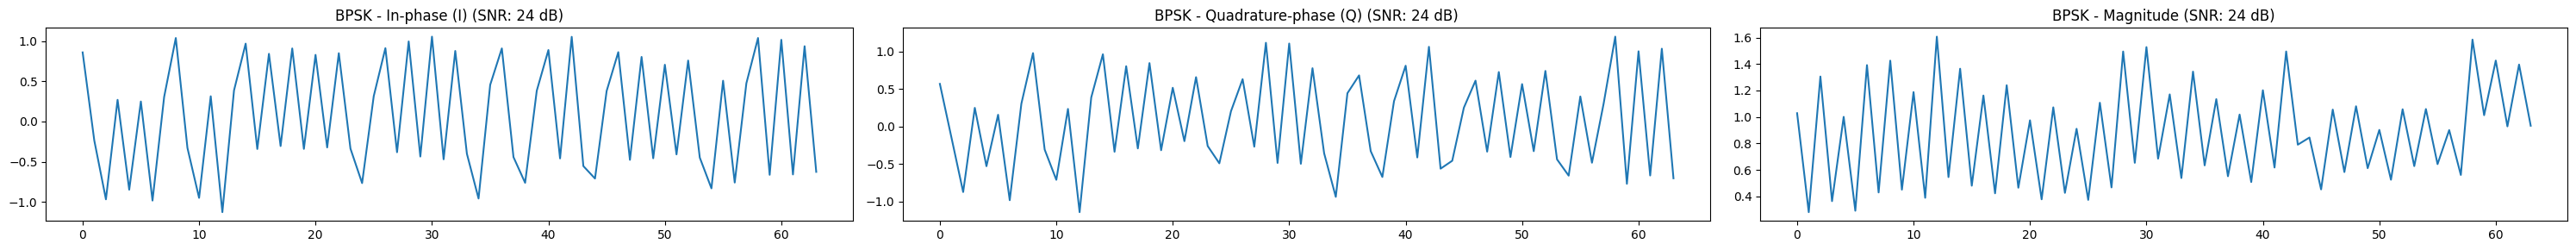

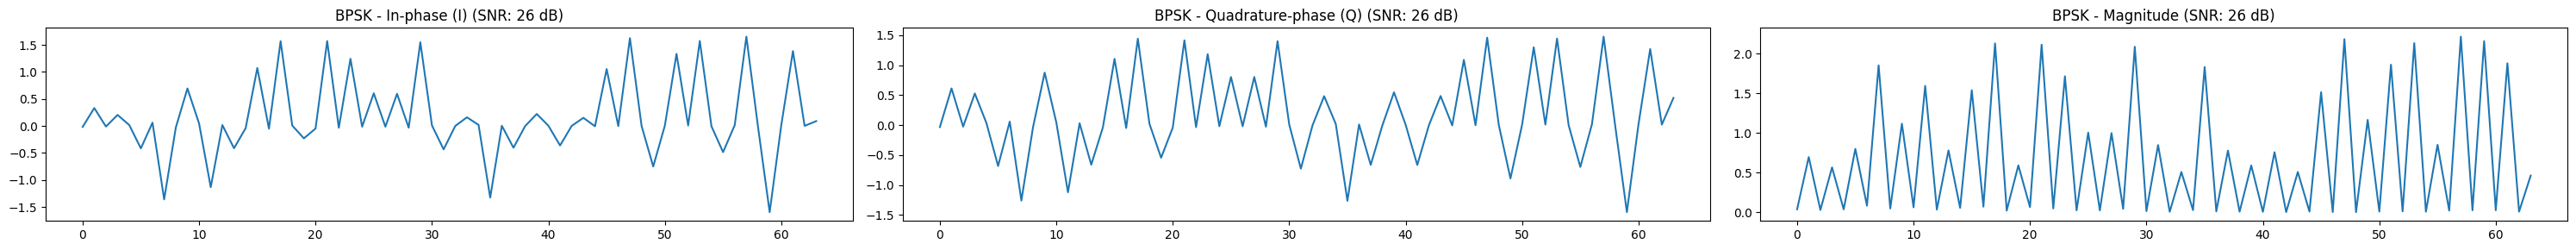

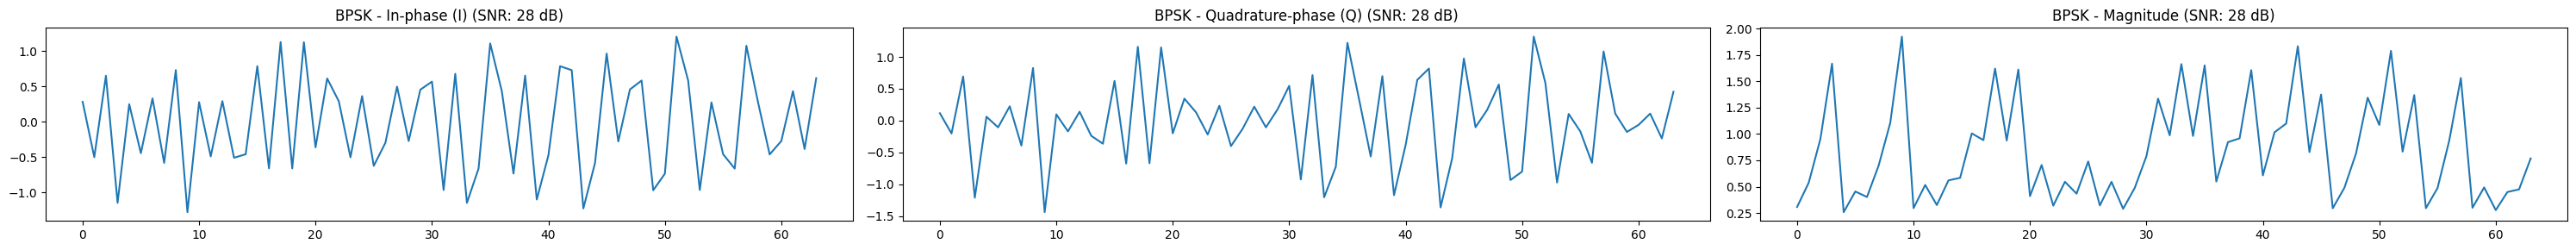

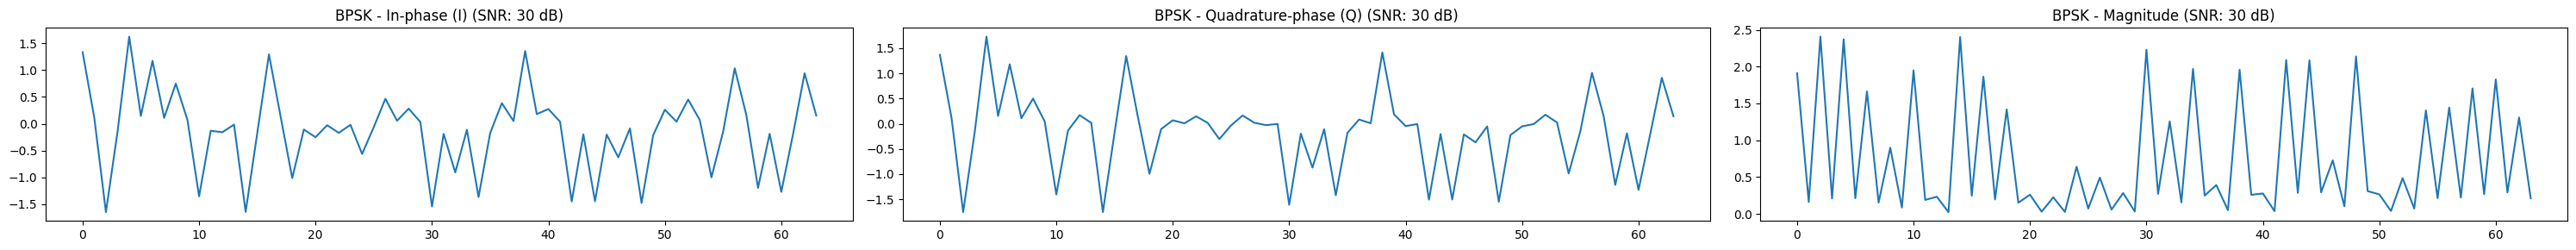

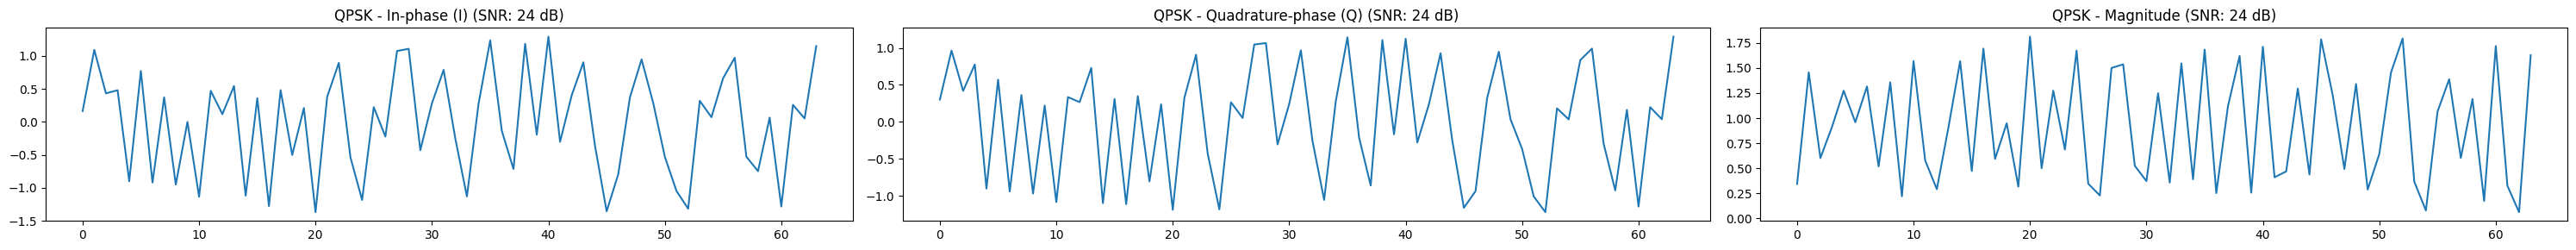

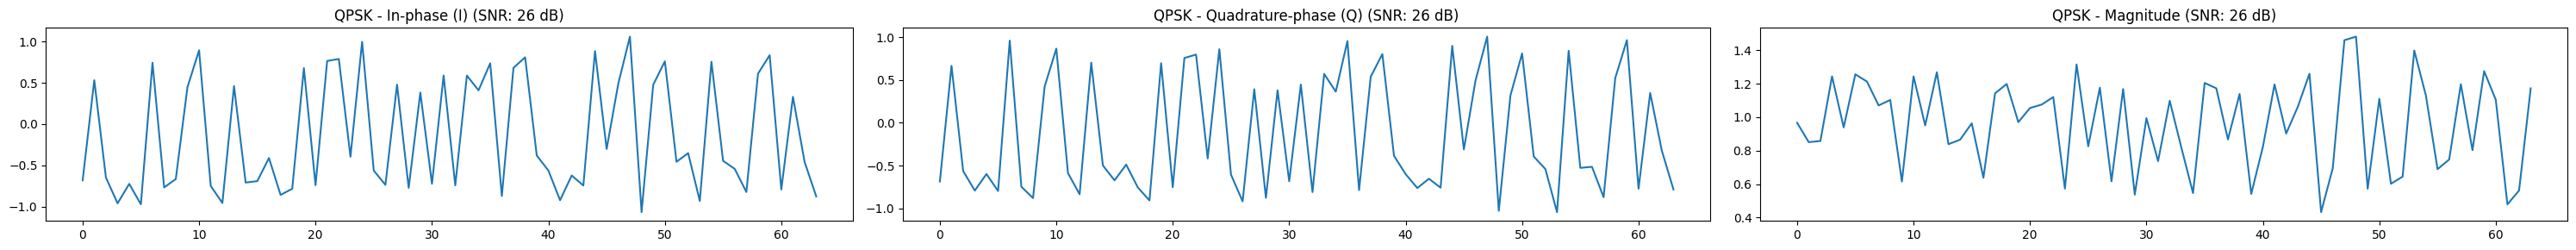

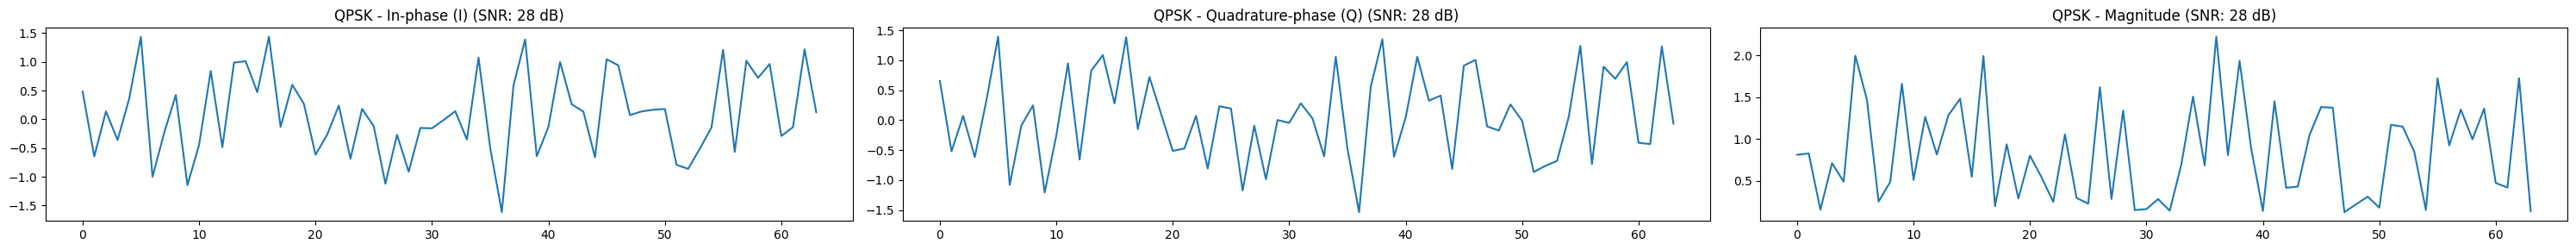

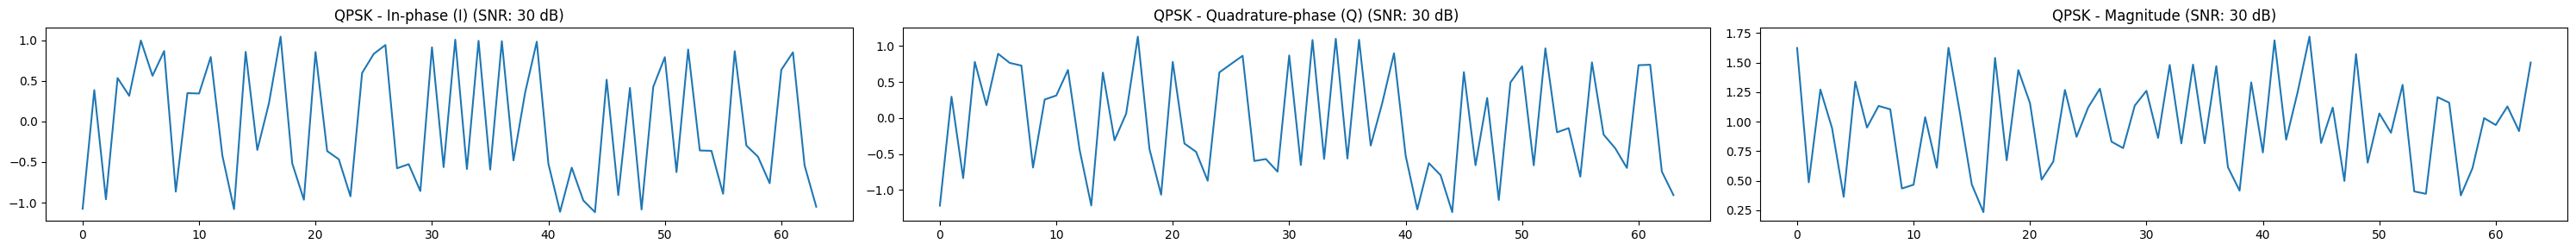

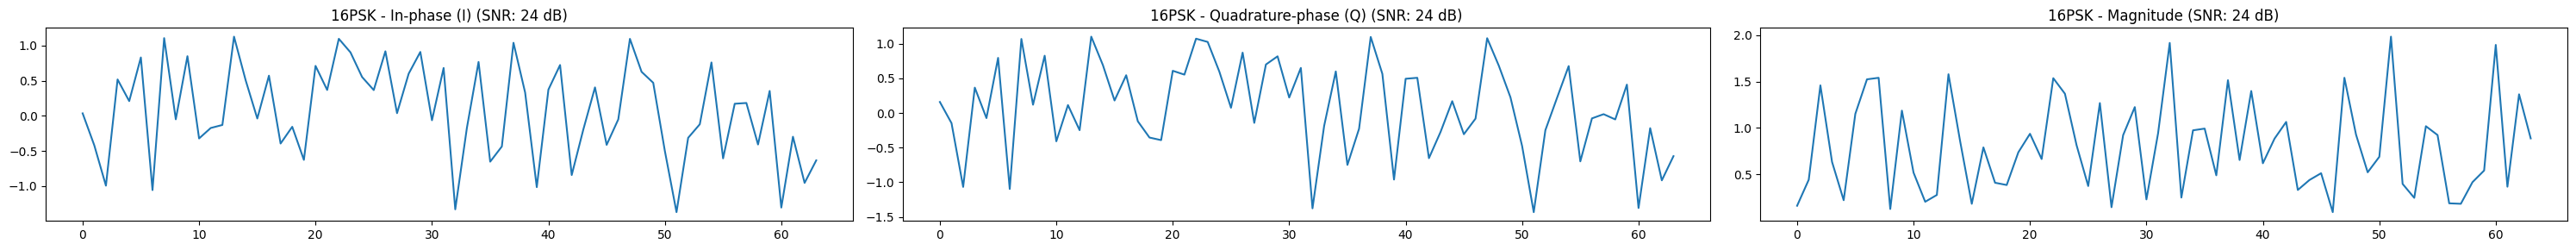

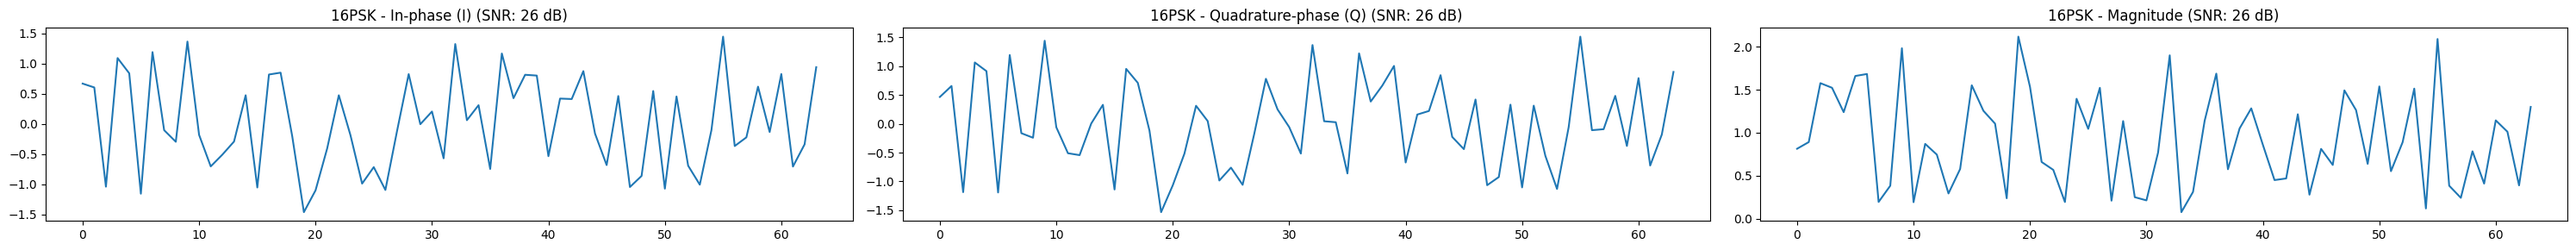

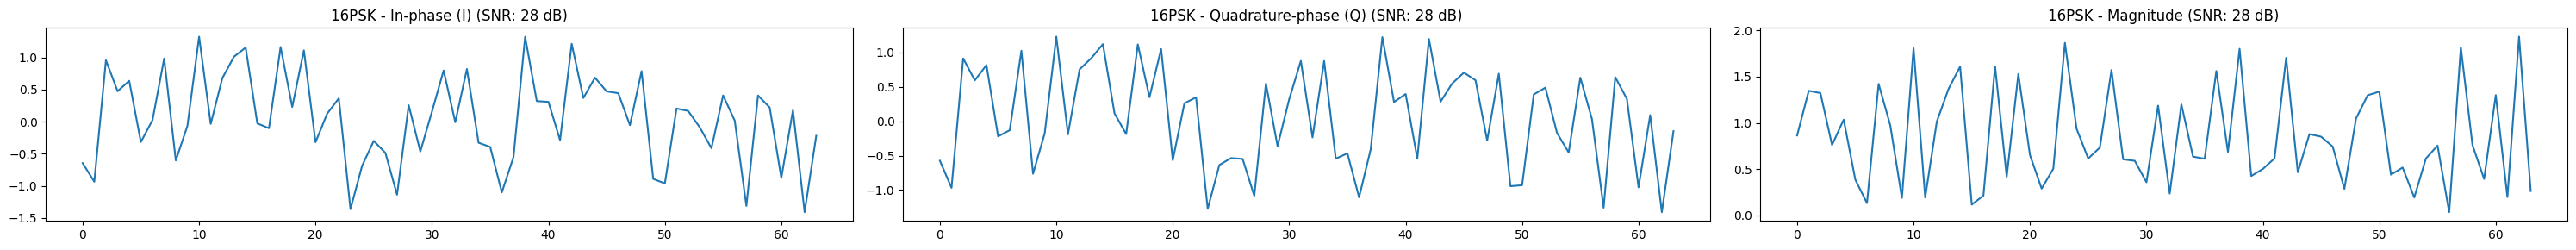

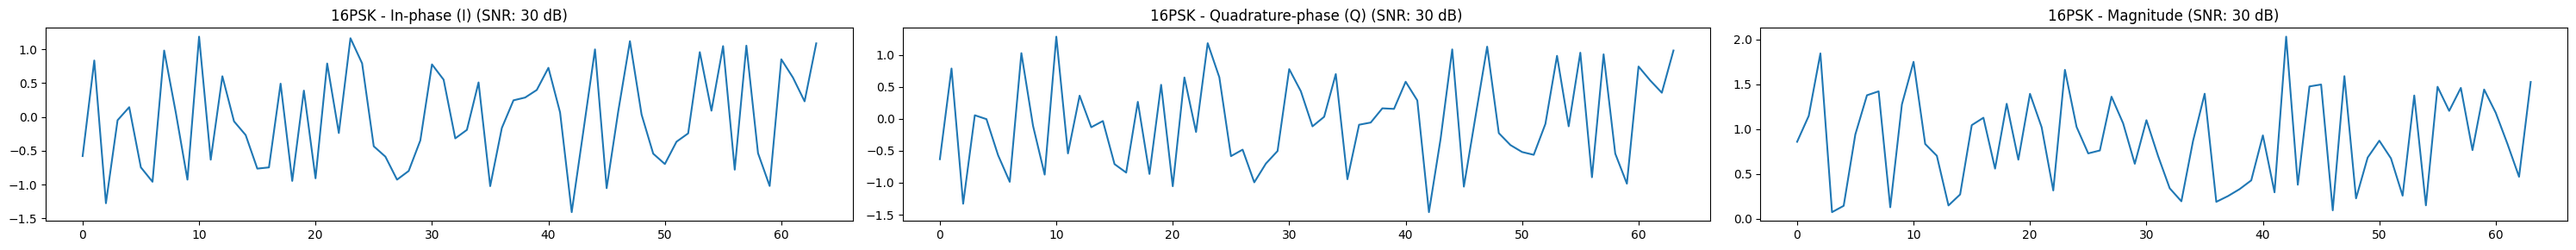

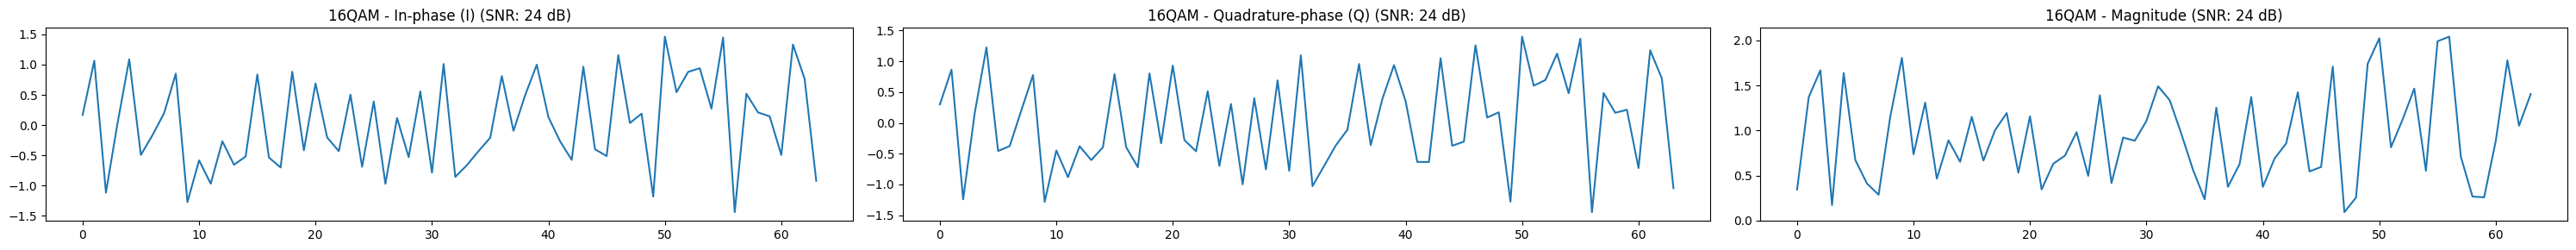

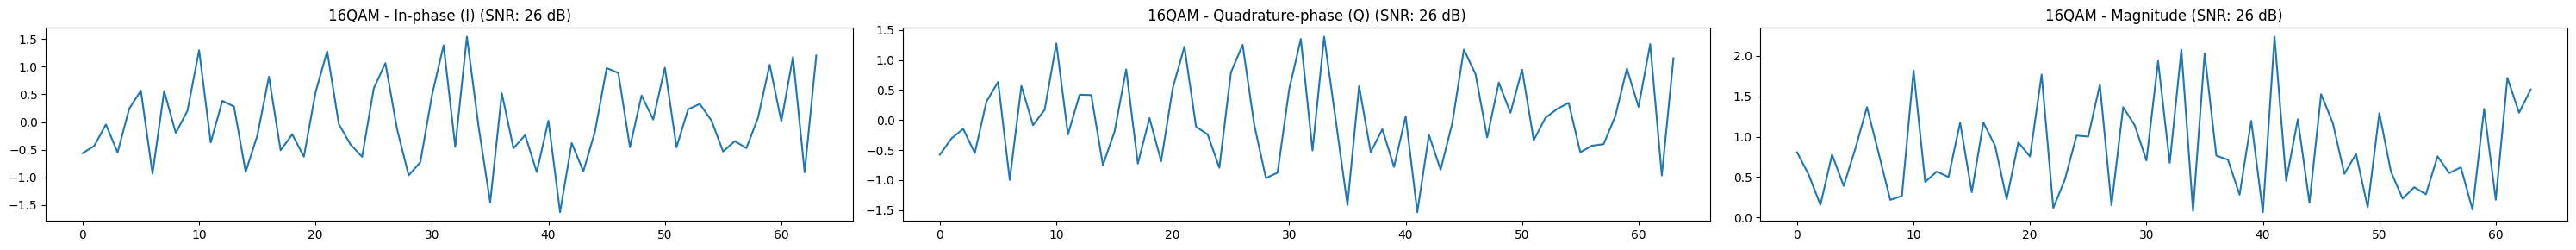

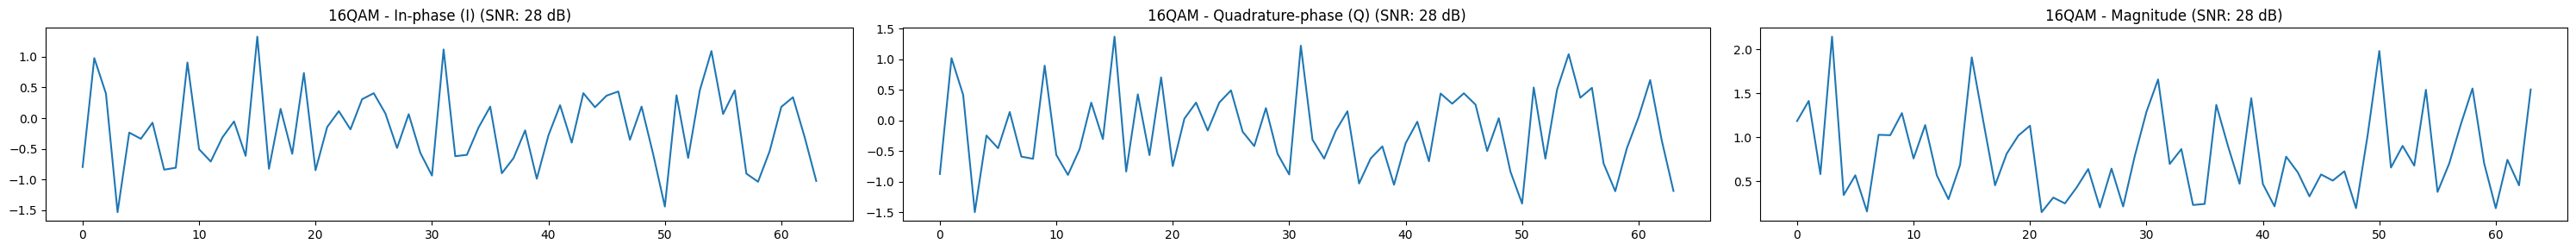

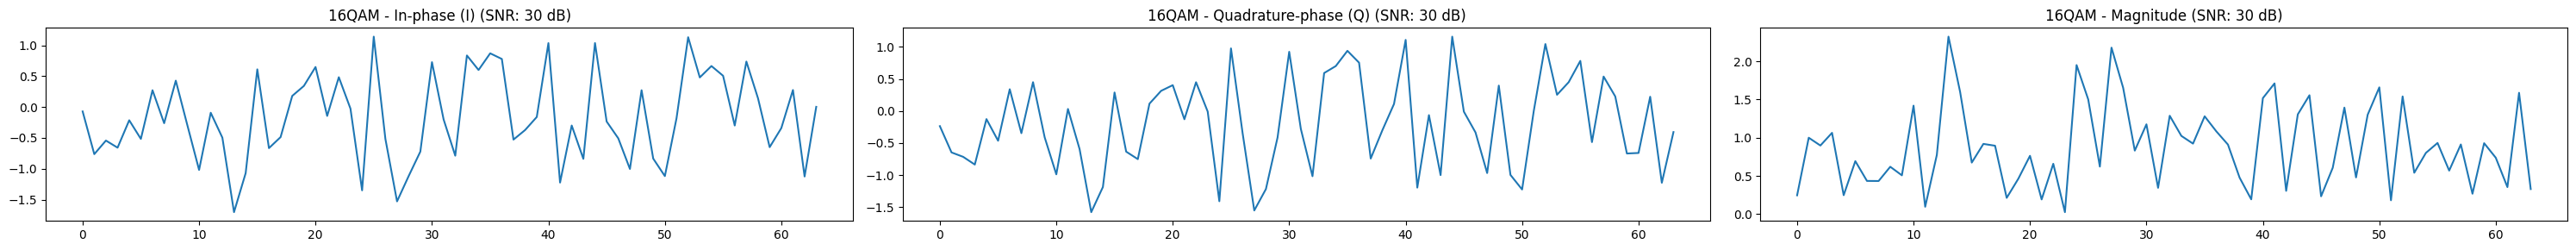

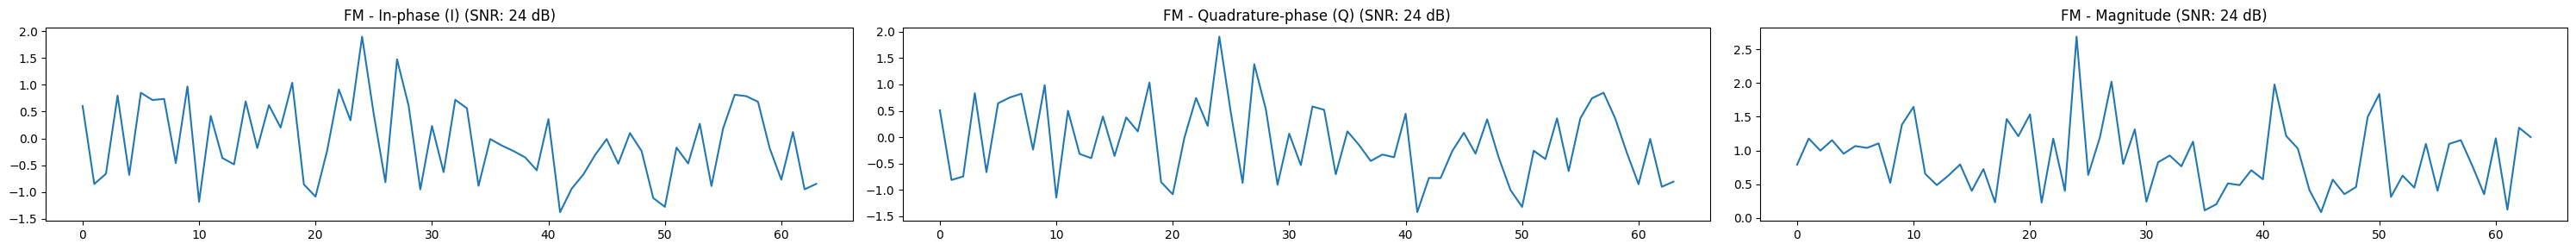

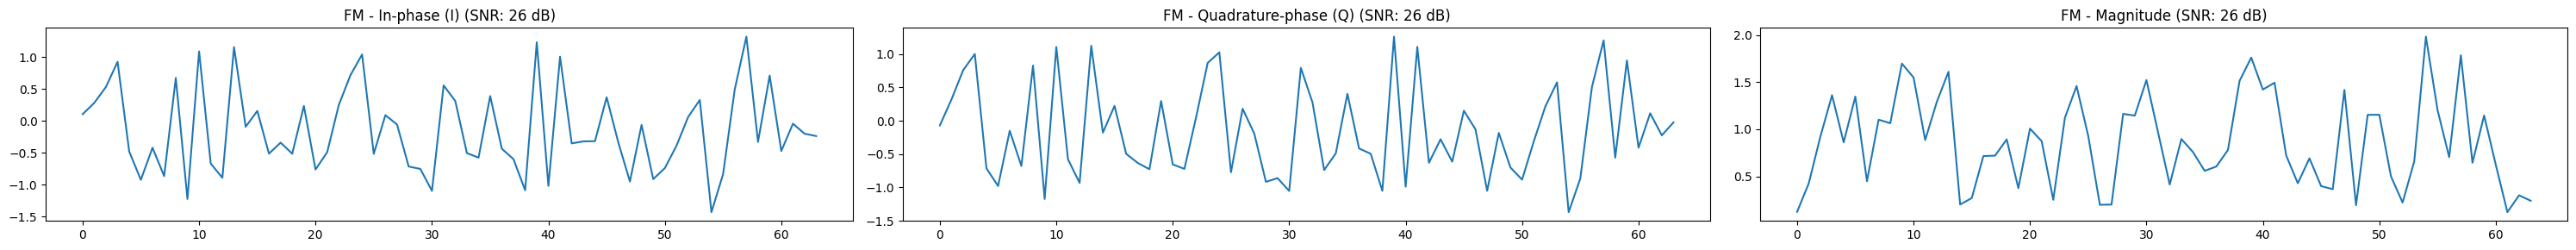

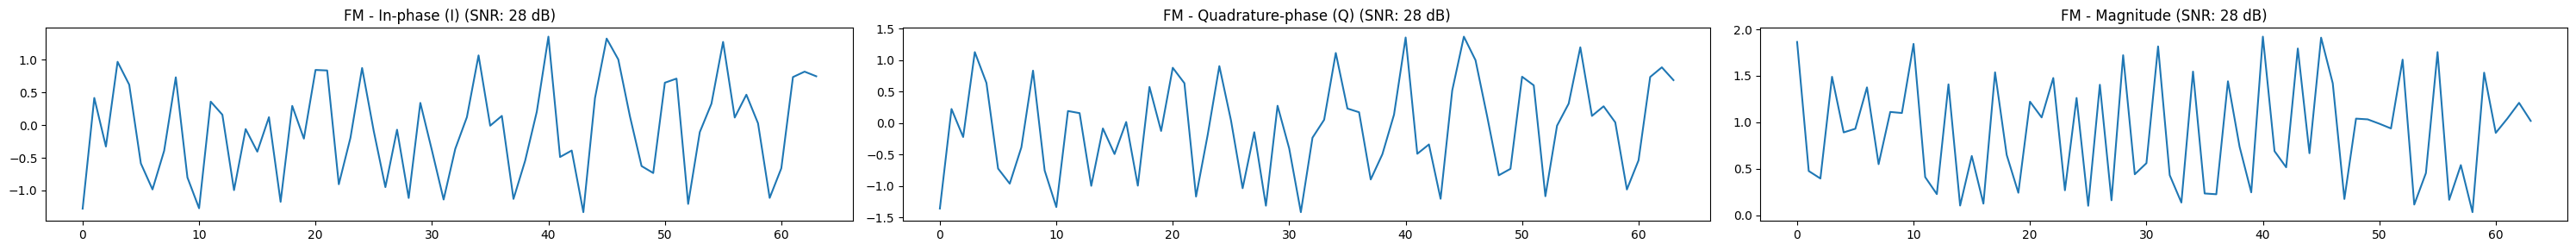

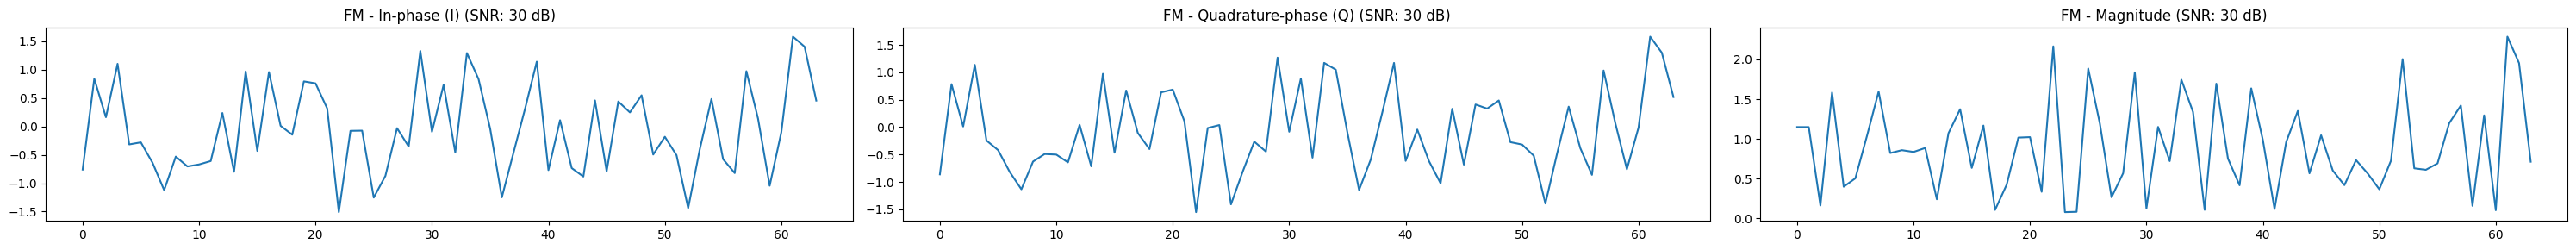

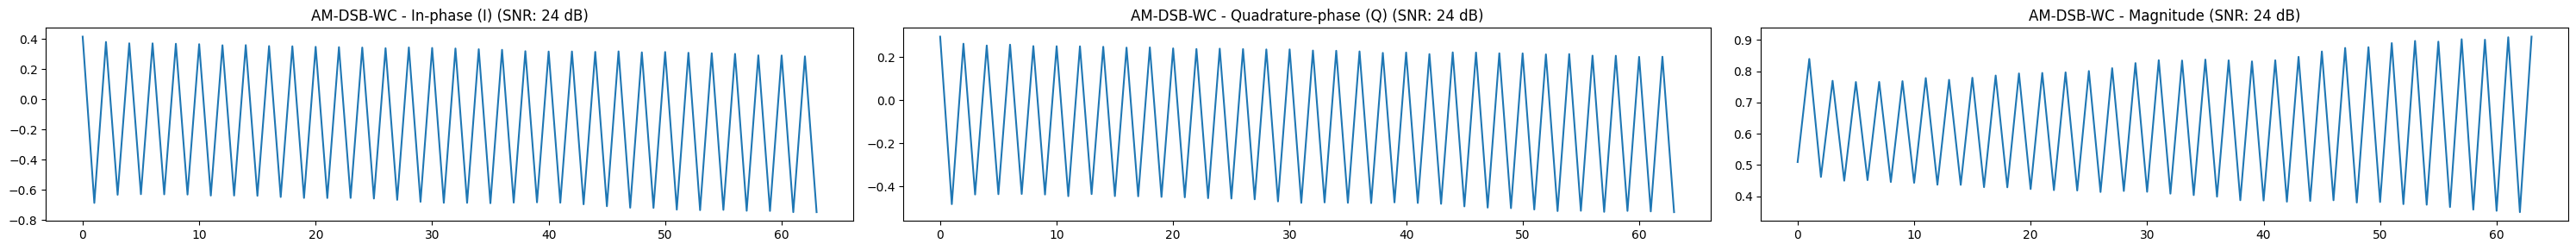

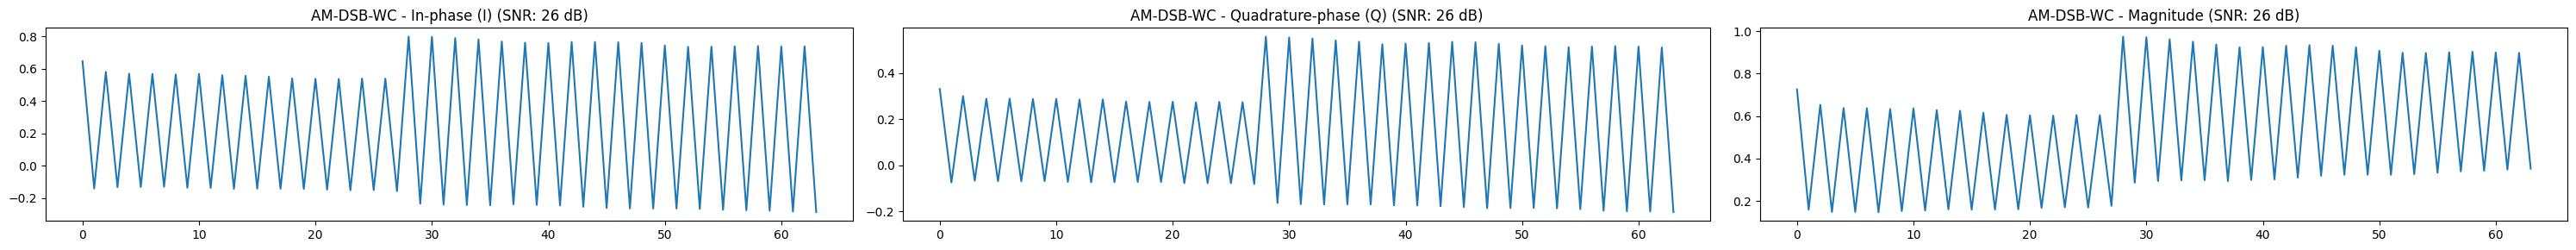

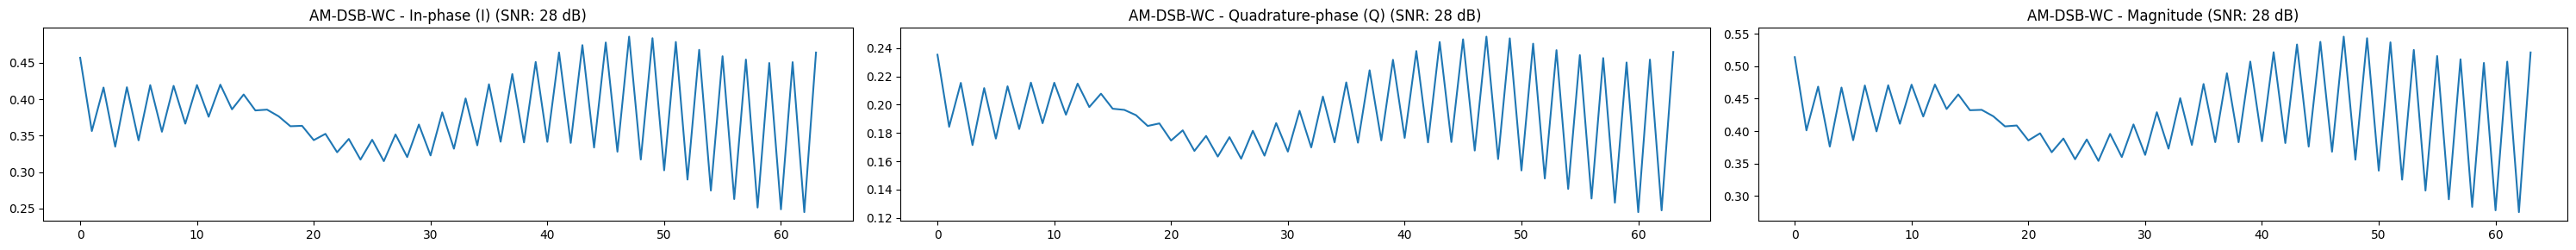

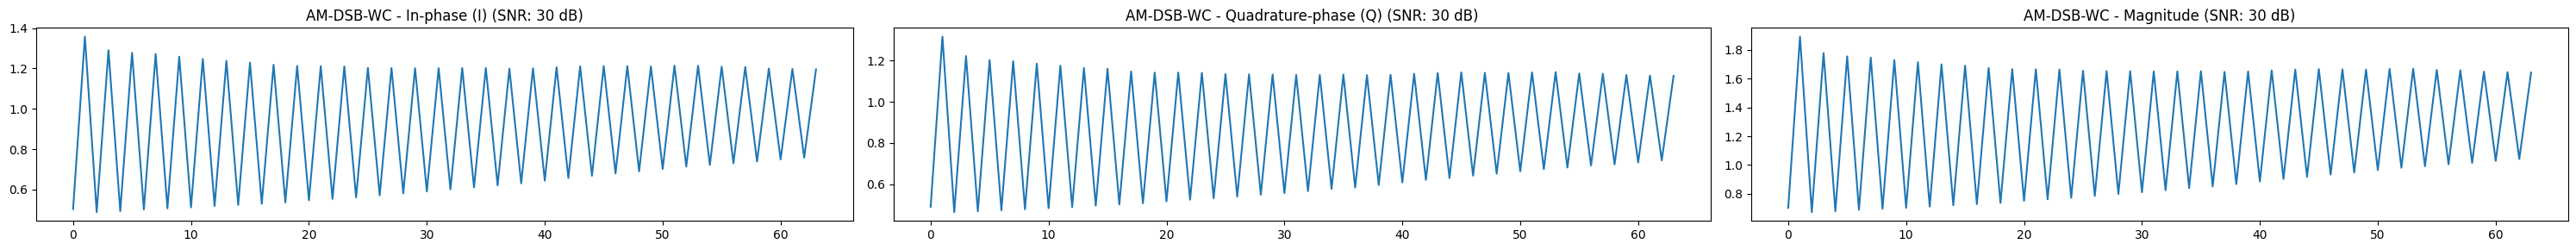

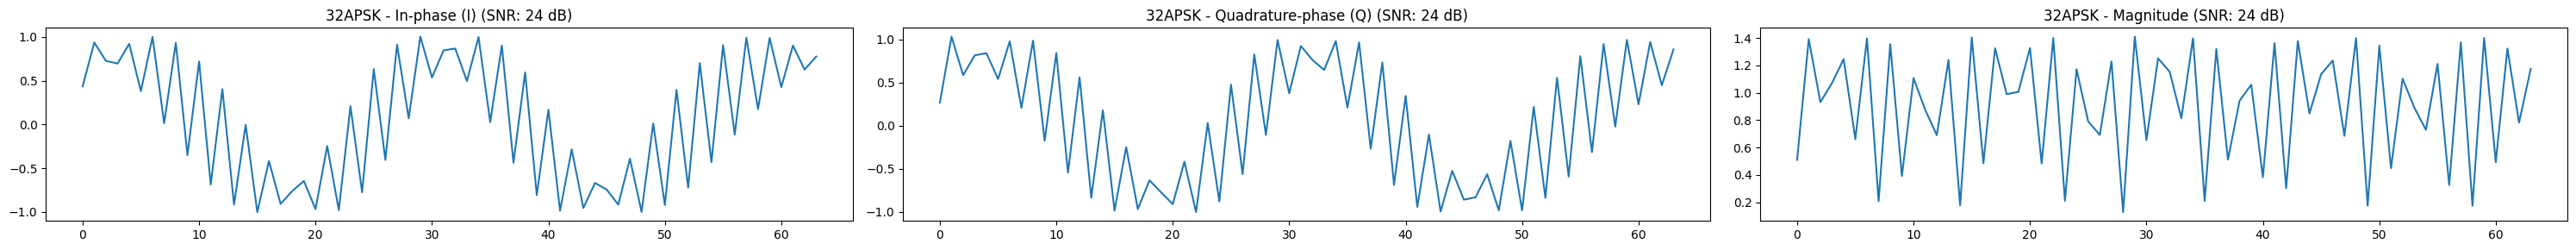

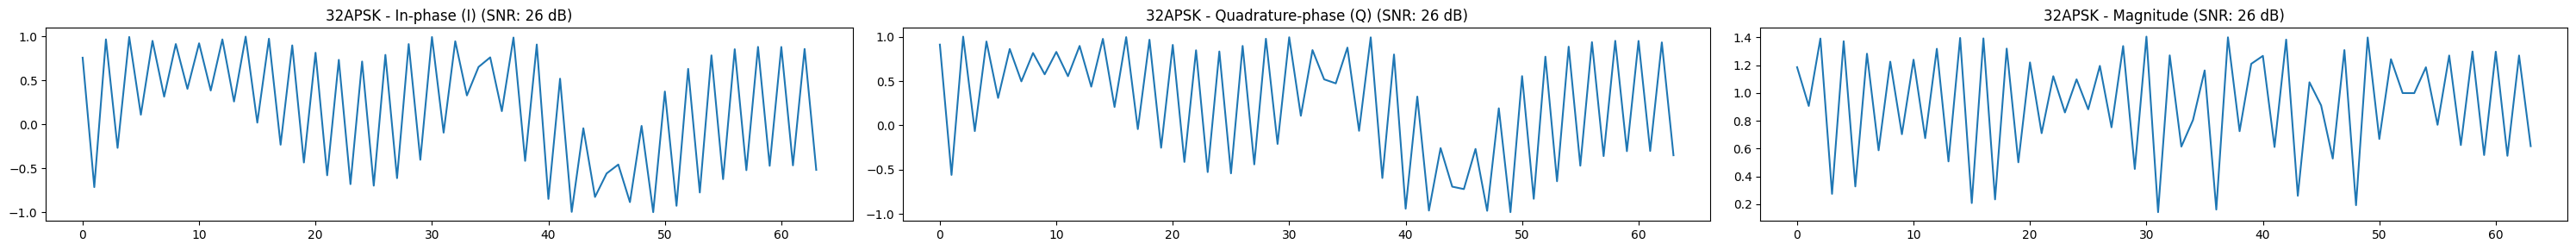

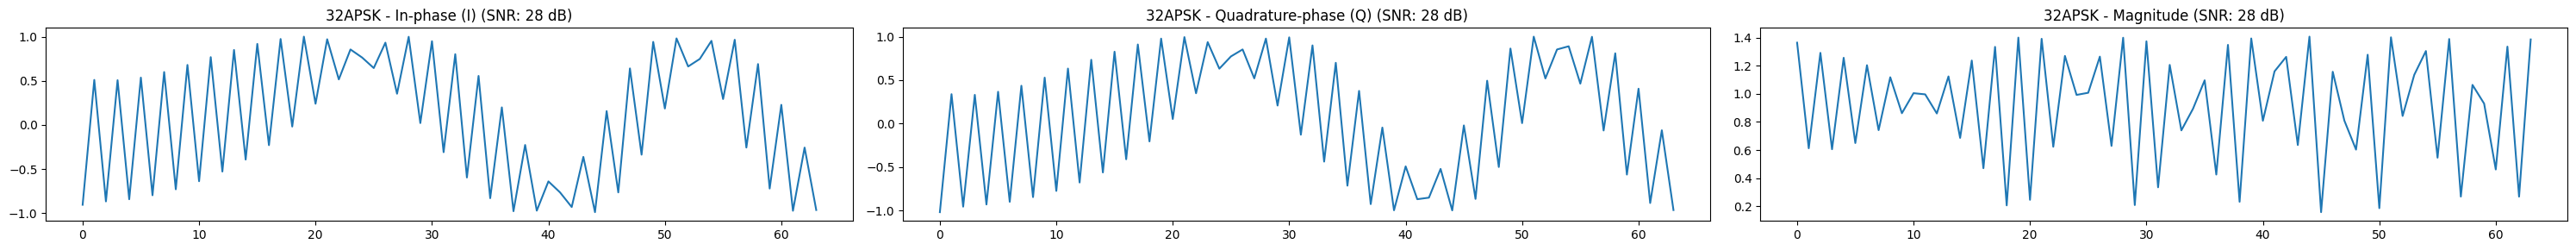

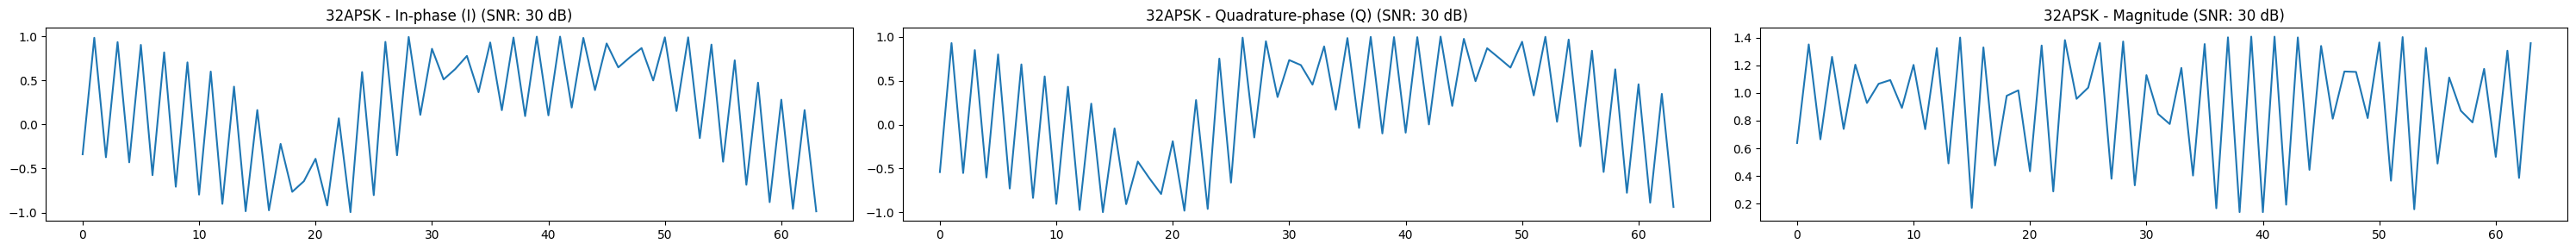

In [13]:
X, Y, Z, class_ids,classes = load_data(dataset_path, selected_classes_id, selected_modulation_classes)
for mod in classes:
    for snr in range(24,32,2):
        plot_signals_by_modulation_snr(X, Y, Z, classes, mod, snr, 1)

Original y_data shape: (131072, 24)
Columns with non-zero sum: 8
Filtered y_data shape: (131072, 8)
Training data shape: (78643, 32, 32, 2)
Testing data shape: (52429, 32, 32, 2)
Number of classes: 8


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Loaded pipeline from /kaggle/input/xgbnet/pytorch/default/1/trained_pipeline.joblib


y_test shape: (52429,), unique values: [0 1 2 3 4 5 6 7]
y_pred shape: (52429,), unique values: [0 1 2 3 4 5 6 7]
Number of class_names: 8
Accuracy: 0.9956
Classification Report:
              precision    recall  f1-score   support

        4ASK       1.00      1.00      1.00      6553
        BPSK       1.00      1.00      1.00      6553
        QPSK       1.00      1.00      1.00      6554
       16PSK       1.00      1.00      1.00      6554
       16QAM       0.98      0.99      0.98      6554
          FM       0.99      0.98      0.98      6553
   AM-DSB-WC       1.00      1.00      1.00      6554
      32APSK       1.00      1.00      1.00      6554

    accuracy                           1.00     52429
   macro avg       1.00      1.00      1.00     52429
weighted avg       1.00      1.00      1.00     52429



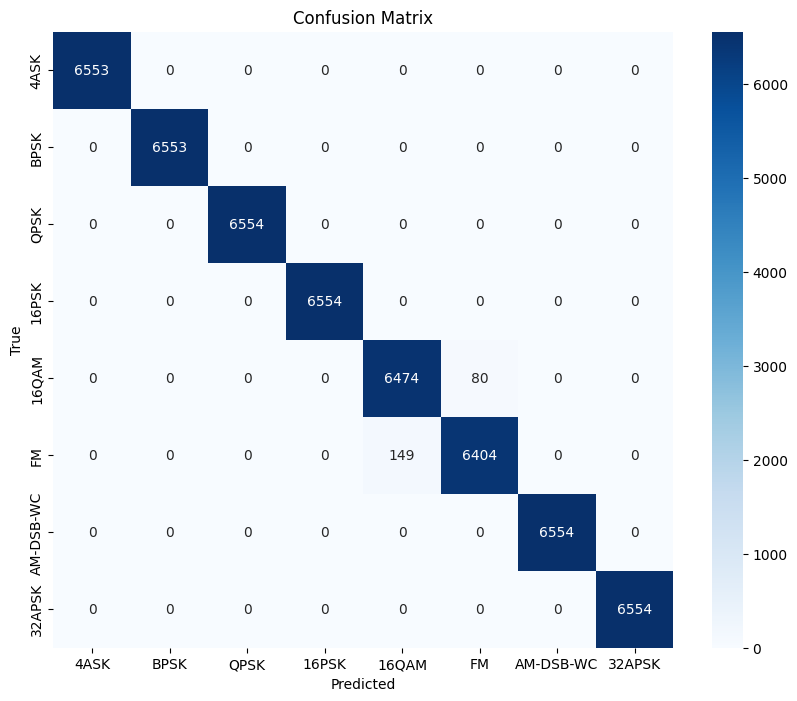

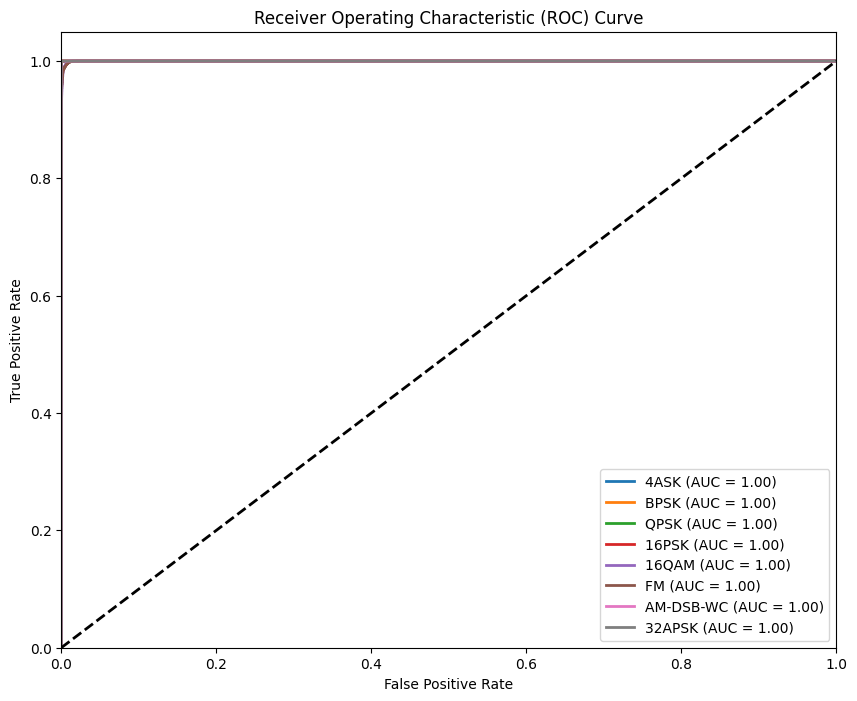

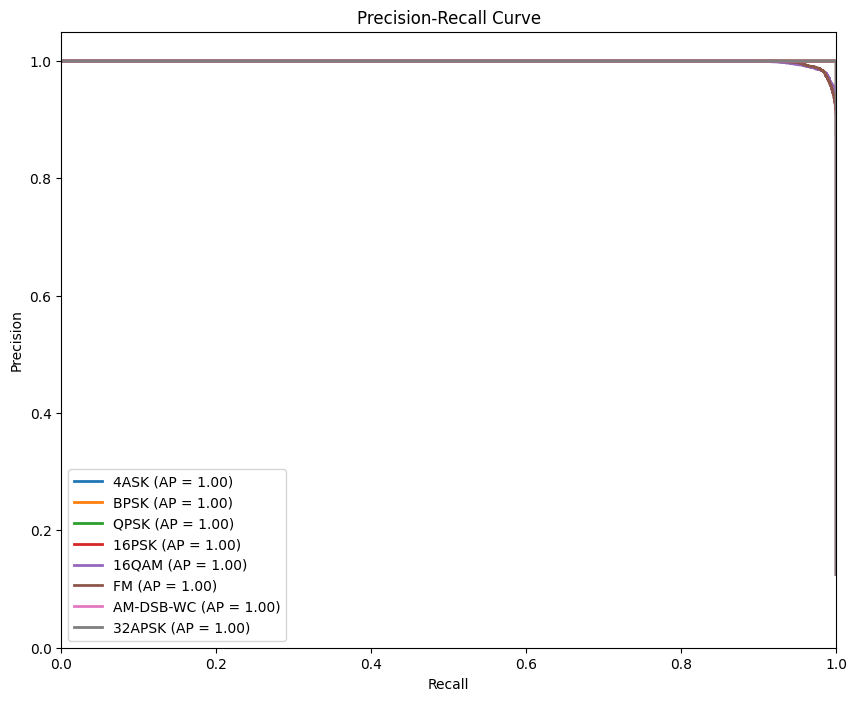

In [18]:
# Load test data
_,X_test,_,y_test,_,_,class_names = load_and_split_data(dataset_path, selected_classes_id, selected_modulation_classes)

# Load the trained pipeline
pipeline = joblib.load(pipeline_path)
print(f"Loaded pipeline from {pipeline_path}")

# Move the feature extractor to the correct device
pipeline.named_steps['feature_extraction'].model.to(device)

# Evaluate the pipeline
evaluate_pipeline(pipeline, X_test, y_test, class_names)